In [1]:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import completions_module as cmodule

import cartopy.crs as crs
import cartopy.feature as cf
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader

Load data.

In [2]:
# ucar list
all_files = glob.glob("../data/completions_*.csv")
all_files = sorted(all_files)
df_ucar = cmodule.open_and_concat(all_files)

# hsi list
all_files = glob.glob("../data/hsi_completions_*.csv")
all_files = sorted(all_files)
df_hsis = cmodule.open_and_concat(all_files)

# ehi list
all_files = glob.glob("../data/emerginghsi_completions_*.csv")
all_files = sorted(all_files)
df_ehis = cmodule.open_and_concat(all_files)

# uni locations
uni_loc = pd.read_csv('../data/hd2020_data_stata.csv', encoding='ISO-8859-1')  # uni locations

Concatenate the data from UCAR, HSI, EHI lists.

In [3]:
all_unis = pd.concat([df_ucar, df_hsis, df_ehis])

### Filter top ranked schools

In [4]:
# -------

top_cut = 30

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Hispanic or Latino total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Hispanic or Latino total']]

top_his_atm = df.sort_values('Hispanic or Latino total',ascending=False).head(top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.atmospheric_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Grand total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Grand total']]

top_all_atm = df.sort_values('Grand total',ascending=False).head(top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Hispanic or Latino total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Hispanic or Latino total']]

top_his_eas = df.sort_values('Hispanic or Latino total',ascending=False).head(top_cut)

# -------

df = cmodule.bs_degrees(all_unis)
df = cmodule.earth_and_atmos_sciences(df)

school_names = df.groupby(
    'institution name').sum()['Grand total'].sort_values(
    ascending=False).head(top_cut).index

df = df[df['institution name'].isin(school_names)].groupby(
    'institution name').sum()[['Grand total']]

top_all_eas = df.sort_values('Grand total',ascending=False).head(top_cut)

# -------

Identify school names that don't match lists

In [5]:
for num, i in enumerate(top_his_atm.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_all_atm.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_his_eas.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)
        
for num, i in enumerate(top_all_eas.index):
    if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:
        print(i)

University of Illinois at Urbana-Champaign
University of Illinois at Urbana-Champaign
University of Illinois at Urbana-Champaign


In [6]:
#uni_loc[uni_loc['STABBR']=='NY']['INSTNM'].unique()

Grab uni locations

In [7]:
def grab_uni_locations(top_, uni_loc):
    """
    Extract the locations of the filtered universities.
    
    Args:
        top_: list of top schools.
        uni_loc: dataframe of school locations.
        
    """
    uni_ = []
    lat_ = []
    lon_ = []
    frq_ = []

    for num, i in enumerate(top_.index):

        if not uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:

            uni_.append(uni_loc[uni_loc['INSTNM']==i]['INSTNM'].to_numpy()[0])
            lon_.append(uni_loc[uni_loc['INSTNM']==i]['LONGITUD'].to_numpy()[0])
            lat_.append(uni_loc[uni_loc['INSTNM']==i]['LATITUDE'].to_numpy()[0])
            frq_.append(top_.iloc[num].values)

        if uni_loc[uni_loc['INSTNM']==i][['INSTNM','LONGITUD','LATITUDE']].empty:

            if i == 'University of Illinois at Urbana-Champaign':

                uni_.append(uni_loc[uni_loc['INSTNM'].str.contains('University of Illinois Urbana-Champaign')]['INSTNM'].to_numpy()[0])
                lon_.append(uni_loc[uni_loc['INSTNM'].str.contains('University of Illinois Urbana-Champaign')]['LONGITUD'].to_numpy()[0])
                lat_.append(uni_loc[uni_loc['INSTNM'].str.contains('University of Illinois Urbana-Champaign')]['LATITUDE'].to_numpy()[0])
                frq_.append(top_.iloc[num].values)

            if i == 'SUNY College at Brockport':

                uni_.append(uni_loc[uni_loc['INSTNM'].str.contains('SUNY Brockport')]['INSTNM'].to_numpy()[0])
                lon_.append(uni_loc[uni_loc['INSTNM'].str.contains('SUNY Brockport')]['LONGITUD'].to_numpy()[0])
                lat_.append(uni_loc[uni_loc['INSTNM'].str.contains('SUNY Brockport')]['LATITUDE'].to_numpy()[0])
                frq_.append(top_.iloc[num].values)
                
    return uni_, lat_, lon_, np.array(frq_)

def minmax_norm(frq_):
    return (frq_ - frq_.min()) / (frq_.max() - frq_.min())

In [8]:
uni_all_atm, lat_all_atm, lon_all_atm, frq_all_atm = grab_uni_locations(top_all_atm, uni_loc)
uni_his_atm, lat_his_atm, lon_his_atm, frq_his_atm = grab_uni_locations(top_his_atm, uni_loc)
uni_all_eas, lat_all_eas, lon_all_eas, frq_all_eas = grab_uni_locations(top_all_eas, uni_loc)
uni_his_eas, lat_his_eas, lon_his_eas, frq_his_eas = grab_uni_locations(top_his_eas, uni_loc)

Create uni abbreviations for figures

In [9]:
abv_all_atm = ['PSU', 'OU', 'Mizzou', 'Texas A&M-CS', 'FSU', 'Valparaiso', 'NC State', 'Millersville', 'Embry-Riddle', 'Illinois',
               'UW', 'ISU', 'NIU', 'UW-Madison', 'VT', 'Rutgers', 'SUNY Oswego', 'USA', 'UNC-Char', 'UCLA', 'SCSU', 
               'SUNY Albany','SUNY-Mari','Plymouth','CMU','UNC-Ash','UND','Cornell', 'UNL', 'Kansas']

abv_all_eas = ['PSU', 'Texas A&M-CS', 'UW', 'Miss State', 'UHouston', 'US Naval', 'OU', 'UT-Austin', 'UCSC', 'UNC-Char', 'UW-Madison',
               'NC State', 'CU Boulder', 'UC Irvine', 'MSU', 'UCSB', 'Stanford', 'Illinois', 'VT', 'FSU', 'UA', 'Mizzou', 'UWyoming', 'UM',
               'WSU', 'OSU', 'UC Davis', 'Millersville', 'NIU', 'UC Berkeley']

abv_his_atm = ['Texas A&M-CS', 'FSU', 'U. Incarnate Word', 'UCLA', 'Illinois', 'PSU', 'SUNY-Mari', 'OU', 'Embry-Riddle', 'Cornell', 'NIU',
               'SJSU', 'UW', 'UM', 'VT', 'Valparaiso', 'Rutgers', 'SUNY Oswego', 'Stony Brook', 'SUNY Albany', 'NC State', 'Mizzou', 'Embry-Riddle\nPrescott',
               'UC Davis', 'USA', 'Air Force', 'UL Monroe', 'Purdue', 'Millersville', 'Kansas']
               
abv_his_eas = ['Texas A&M-CS', 'UPR Mayaguez', 'UHouston', 'UT-El Paso', 'UT-Austin', 'FIU', 'PSU',
               'UCSC', 'UC Irvine', 'UT-SA', 'UCSB', 'CSUF', 'US Naval', 'CSU-Ba', 
               'UCLA', 'Stanford', 'TT', 'UW', 'Columbia', 'UC Davis', 'UC Berkeley', 'CSPU', 'UA', 'FSU', 'Texas A&M-K', 'UT-Arlington',
               'CSULA', 'Texas A&M-CC', 'Humboldt', 'UN-LV']

Cartopy states

In [10]:
reader = shpreader.Reader(f'/glade/work/molina/DATA/cartopy_usstates/ne_50m_admin_1_states_provinces_lines.shp')
states = list(reader.geometries())
STATES = cfeature.ShapelyFeature(states, crs.PlateCarree())

## Figure

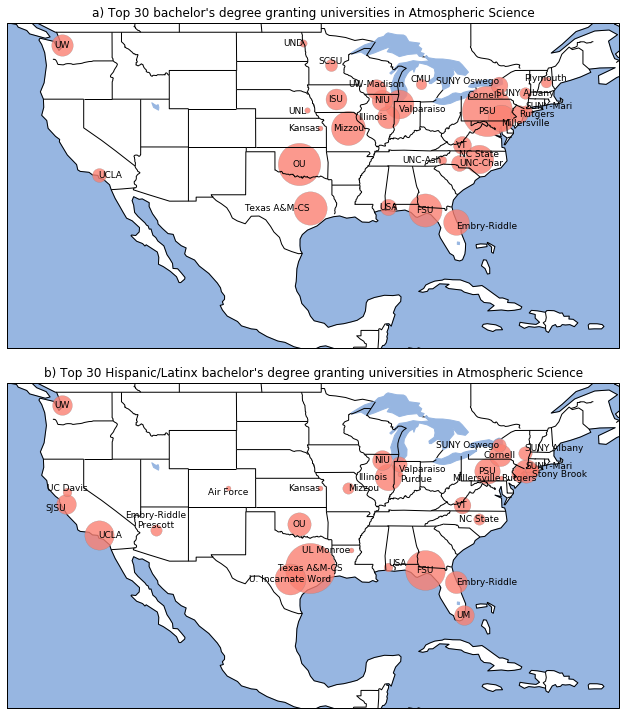

In [11]:
#-----------------------%

fig = plt.figure(figsize=(8.5,10.))

#-----------------------%

ax1 = fig.add_axes([0.0, 0.5, 1.0, 0.475], projection=crs.PlateCarree())

ax1.set_title(f"a) Top {top_cut} bachelor's degree granting universities in Atmospheric Science",
              fontsize=12)

#-----------------------%

va_list = ['center', 'center', 'center', 'center', 'center', 'top', 'bottom', 'top', 
           'top', 'center', 'center', 'center', 'center', 'bottom', 'center', 'center', 
           'bottom', 'center', 'center', 'center', 'bottom', 'center','bottom','bottom', 
           'bottom', 'center', 'center','center', 'center', 'center']

ha_list = ['center', 'center', 'center', 'right', 'center', 'left', 'center', 'left', 
           'left', 'right', 'center', 'center','center', 'center', 'center', 'left', 
           'right', 'center', 'left', 'left', 'center', 'center', 'left', 'center', 
           'center', 'right', 'right', 'right', 'right', 'right']

#-----------------------%

ax1.coastlines()
ax1.add_feature(cf.BORDERS)
ax1.add_feature(cf.OCEAN)
ax1.add_feature(cf.LAKES)
ax1.add_feature(STATES, facecolor='none', edgecolor='k', zorder=90)

ax1.set_extent([-128, -64, 16, 50], crs=crs.PlateCarree())

for un, la, lo, fr, ab, va_val, ha_val in zip(uni_all_atm, lat_all_atm, lon_all_atm, minmax_norm(frq_all_atm), 
                                              abv_all_atm, va_list, ha_list):

    ax1.scatter(x=lo, y=la, color="salmon", s=(fr+0.01) * 2500,
                alpha=0.8, edgecolor='grey', lw=0.25, transform=crs.PlateCarree(), zorder=10)
    
    ax1.annotate(ab, xy=(lo, la), xycoords=crs.PlateCarree()._as_mpl_transform(ax1),
                 xytext=(lo, la), textcoords=crs.PlateCarree()._as_mpl_transform(ax1),
                 zorder=100, fontsize=9, weight='normal', ha=ha_val, va=va_val)

#-----------------------%

ax2 = fig.add_axes([0.0, 0., 1.0, 0.475], projection=crs.PlateCarree())

ax2.set_title(f"b) Top {top_cut} Hispanic/Latinx bachelor's degree granting universities in Atmospheric Science",
              fontsize=12)

#-----------------------%

va_list = ['center', 'center', 'center', 'center', 'center', 'center', 'bottom', 
           'center', 'center', 'center', 'center', 'top', 'center', 'center', 
           'center', 'top', 'top', 'center', 'top', 'bottom', 'center', 'center', 
           'bottom', 'bottom', 'bottom', 'top', 'center', 'top', 'center', 'center']

ha_list = ['center', 'center', 'center', 'left', 'right', 'center', 'left', 
           'center', 'left', 'center', 'center', 'right', 'center', 'center',
           'center', 'left', 'center', 'right', 'left', 'left', 'center', 'left',
           'center', 'center', 'left', 'center', 'right', 'left', 'right', 'right']

#-----------------------%

ax2.coastlines()
ax2.add_feature(cf.BORDERS)
ax2.add_feature(cf.OCEAN)
ax2.add_feature(cf.LAKES)
ax2.add_feature(STATES, facecolor='none', edgecolor='k', zorder=90)

ax2.set_extent([-128, -64, 16, 50], crs=crs.PlateCarree())

for un, la, lo, fr, ab, va_val, ha_val in zip(uni_his_atm, lat_his_atm, lon_his_atm, minmax_norm(frq_his_atm), 
                                              abv_his_atm, va_list, ha_list):

    ax2.scatter(x=lo, y=la, color="salmon", s=(fr+0.01) * 2500,
                alpha=0.8, edgecolor='grey', lw=0.25, transform=crs.PlateCarree(), zorder=10)
    
    ax2.annotate(ab, xy=(lo, la), xycoords=crs.PlateCarree()._as_mpl_transform(ax2),
                xytext=(lo, la), textcoords=crs.PlateCarree()._as_mpl_transform(ax2),
                zorder=100, fontsize=9, weight='normal', ha=ha_val, va=va_val)

#-----------------------%

plt.savefig(f"../figures/fig3.png", bbox_inches='tight', dpi=500)
plt.show()

#-----------------------%